# Single-ancilla ground state preparation via Lindbladians

References:
- Zhiyan Ding, Chi-Fang Chen and Lin Lin  
  Single-ancilla ground state preparation:
  [arXiv:2308.15676 [quant-ph]](https://arxiv.org/abs/2308.15676)

In [2]:
import numpy as np
from scipy.linalg import sqrtm, cosm, sinm, expm
import matplotlib.pyplot as plt
import scipy.linalg as la
from qutip import *
import math
import qib

## Create Hamiltonian for Fermi-Hubbard model

In [7]:
FermiHubbard_L = 2 # Size of the system
FermiHubbard_t = 1.0 # Kinetic hopping coefficient
FermiHubbard_u = 0.0 # Potential interaction strength
FermiHubbard_latt = qib.lattice.IntegerLattice((FermiHubbard_L,), pbc=True)
field_hamil = qib.field.Field(qib.field.ParticleType.FERMION, FermiHubbard_latt)

# Fermi-Hubbard Hamiltonian
H_Fermi_Hubbard = (
    qib.operator.FermiHubbardHamiltonian(field_hamil, FermiHubbard_t, FermiHubbard_u, False)
    .as_matrix()
    .todense()
)

print("H:", H_Fermi_Hubbard)

H: [[ 0.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  0.]]


In [8]:
import numpy as np

ket_0 = np.array([[1.0, 0.0]])
ket_1 = np.array([[0.0, 1.0]])

print("|ket_0><ket_0| = \n", np.kron(ket_0.conj().T, ket_0))
print("\n")
print("|ket_0> o |ket_0> =\n", np.kron(ket_0, ket_0))
print("\n")
print("|ket_1> o |ket_0> =\n", np.kron(ket_1, ket_0))

I = np.array([[1.0, 0.0], [0.0, 1.0]])
X = np.array([[0.0, 1.0], [1.0, 0.0]])
Y = np.array([[0.0, -1j], [1j, 0.0]])
Z = np.array([[1.0, 0.0], [0.0, -1.0]])

creation_op = (X - (1j * Y)) / 2
annihilation_op = (X + (1j * Y)) / 2

def Pauli_array(op, poz, size):
    ret = 1
    if poz >= size:
        return ret
    for i in range(size):
        if i == poz:
            ret = np.kron(ret, op)
        else:
            ret = np.kron(ret, I)
    return ret

print(Pauli_array(Z, 0, 4))

annihilation_tmp = np.kron((X + (1j * Y)) / 2, I)

# Find ancilla number based on Jump operators
def nr_of_ancilla(num_of_jump):
    if num_of_jump <= 0:
        return 0
    power = num_of_jump
    tmp = np.power(2, power)

    power = power - 1
    while (num_of_jump + 1) <= tmp:

        tmp = np.power(2, power)

    return power + 1


print(nr_of_ancilla(2))

|ket_0><ket_0| = 
 [[1. 0.]
 [0. 0.]]


|ket_0> o |ket_0> =
 [[1. 0. 0. 0.]]


|ket_1> o |ket_0> =
 [[0. 0. 1. 0.]]
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1. -0. -0. -0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -1. -0. -0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -1. -0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -1. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -1. -0. -0. -0.]
 [ 0.  0.  0.

### Fermi Hubbard model

In [9]:
# Utility function, system and constants
import numpy as np

T = 10 * np.pi  # Final time
dt = 0.1  # Time step
J = 2  # Nr of jump operators
taylor_aprox_order = (
    14  # Taylor approximation used for simulating exp(-i*sqrt*(dt)*H_tilde)
)

system_size = FermiHubbard_L  # Hamiltonian system size
system_size_dim = np.power(2, system_size)
ancilla = 2  # Ancillary system size
ancilla_dim = np.power(2, ancilla)
total_system_size = system_size + ancilla  # Total system size
total_system_size_dim = np.power(2, total_system_size)


def H_period(t):
    """Time dependent periodic Hamiltonian for TFIM model

    Args:
        t (float): time stamp

    Returns:
        Qobj: Hamiltonian in the requested time
    """
    return Qobj(H_Fermi_Hubbard)


def V_period(i, t):
    """Periodic jump operators

    Args:
        i (int): Jump operator number
        t (float): Time stamp

    Returns:
        Qobj: Requested jump operator at specified time
    """
    if i == 0:
        return Qobj(-1j * H_period(t).full())
    if i == 1:
        return Qobj(np.eye(system_size_dim))
    if i == 2:
        return Qobj(np.eye(system_size_dim))

    return 0


def outer_prod(left_poz, right_poz, size):
    """Outer product of position i and j: |i><j|

    Args:
        left_poz (int): Position of 1 in ket vector
        right_poz (int): Position of 1 in the bra vector
        size (int): Size of the overall system

    Returns:
        np.array: Requested outer product
    """
    psi_ket = np.array([np.full(size, 0)])
    psi_ket[:, left_poz] = 1
    psi_bra = np.array([np.full(size, 0)])
    psi_bra[:, right_poz] = 1
    return Qobj(psi_ket.conjugate().T @ psi_bra)


def H_period_derivative(t):
    """Time derivative of periodic Hamiltonian

    Args:
        t (float): time stamp

    Returns:
        np.array: The drived Hamiltonian n requested time stamp
    """
    return Qobj(np.zeros((system_size_dim, system_size_dim)))


def V_period_derivative(i, t):
    """Time derivative of jump operators

    Args:
        i (int): Nr of jump operator
        t (float): Time stamp

    Returns:
        Qobj: Time derivative of the selected jump operator
    """
    if i == 1:
        return Qobj(np.zeros((system_size_dim, system_size_dim)))
    if i == 2:
        return Qobj(np.zeros((system_size_dim, system_size_dim)))
    return 0


def sum_of_V_dag_V(t):
    """Summation of jump operators

    Args:
        t (float): Time stamp

    Returns:
        Qobj: Sum of all jump operators
    """
    return Qobj(
        V_period(1, t).full().conj().T @ V_period(1, t).full()
        + V_period(2, t).full().conj().T @ V_period(2, t).full()
    )


def commute(op1, op2):
    """Commuting operator

    Args:
        op1 (np.array): Operator 1
        op2 (np.array): Operator 2

    Returns:
        np.array: [op1, op2]
    """
    return op1 @ op2 - op2 @ op1


def anti_commute(op1, op2):
    """Anti-commuting operator

    Args:
        op1 (np.array): Operator 1
        op2 (np.array): Operator 2

    Returns:
        np.array: {op1, op2}
    """
    return op1 @ op2 + op1 @ op2


# First order simulation
def H_tilde_first_order(t):
    r"""Form of H tilde:
    H =
    sqrt(dt)H   |  V_1^{\dag}   |   V_2^{\dag}  |       0
        V_1     |       0       |       0       |       0
        V_2     |       0       |       0       |       0
        0       |       0       |       0       |       0

        Args:
        t (float): time stamp
    """
    sum = Qobj(
        np.kron(
            outer_prod(0, 0, ancilla_dim).full(), (np.sqrt(dt) * H_period(t)).full()
        )
    )
    # First Row
    for j in np.arange(1, J + 1, 1):
        sum = sum + Qobj(
            np.kron(
                outer_prod(0, j, ancilla_dim).full(),
                V_period(j, t).conj().trans().full(),
            )
        )

    # First Column
    for j in np.arange(1, J + 1, 1):
        sum = sum + Qobj(
            np.kron(outer_prod(j, 0, ancilla_dim).full(), V_period(j, t).full())
        )

    return Qobj(
        sum, dims=[[ancilla_dim, system_size_dim], [ancilla_dim, system_size_dim]]
    )


def H_tilde_second_order(t):
    """Second order approximation fo H tilde
    https://arxiv.org/pdf/2311.15533 page 27 equation B10

    Args:
        t (float): time stamp
    """

    sum_tmp = np.sqrt(dt) * (H_period(t).full()) + np.power(dt, 3 / 2) * (
        0.5 * H_period_derivative(t).full()
        - 1 / 12 * anti_commute(H_period(t).full(), sum_of_V_dag_V(t).full())
    )
    sum = Qobj(np.kron(outer_prod(0, 0, ancilla_dim).full(), sum_tmp))

    for j in np.arange(1, J + 1, 1):
        sum_tmp = V_period(j, t).full() + dt / 2 * (
            anti_commute(V_period(j, t).full(), V_period(0, t).full())
            + V_period_derivative(j, t).full()
            + 1 / 6 * V_period(j, t).full() @ sum_of_V_dag_V(t).full()
            + 1j / 2 * V_period(j, t).full() @ H_period(t).full()
        )
        sum = (
            sum
            + Qobj(np.kron(outer_prod(j, 0, ancilla_dim).full(), sum_tmp))
            + Qobj(np.kron(outer_prod(0, j, ancilla_dim).full(), sum_tmp.conj().T))
        )

    for j in np.arange(1, J + 1, 1):
        sum_tmp = (
            dt
            / np.sqrt(12)
            * (
                commute(V_period(0, t).full(), V_period(j, t).full())
                - V_period_derivative(j, t).full()
            )
        )
        sum = (
            sum
            + Qobj(np.kron(outer_prod(j + J, 0, ancilla_dim).full(), sum_tmp))
            + Qobj(np.kron(outer_prod(0, j + J, ancilla_dim).full(), sum_tmp.conj().T))
        )

    for j in np.arange(1, J + 1, 1):
        for k in np.arange(1, J + 1, 1):
            for l in np.arange(1, J + 1, 1):
                sum_tmp = (
                    dt
                    / np.sqrt(6)
                    * V_period(j, t).full()
                    @ V_period(k, t).full()
                    @ V_period(l, t).full()
                )
                sum = (
                    sum
                    + Qobj(
                        np.kron(
                            outer_prod(
                                j + k * J + l * J * J - J * J + J, 0, ancilla_dim
                            ).full(),
                            sum_tmp,
                        )
                    )
                    + Qobj(
                        np.kron(
                            outer_prod(
                                0, j + k * J + l * J * J - J * J + J, ancilla_dim
                            ).full(),
                            sum_tmp.conj().T,
                        )
                    )
                )

    for j in np.arange(1, J + 1, 1):
        for k in np.arange(1, J + 1, 1):
            sum_tmp = np.sqrt(dt / 2) * V_period(j, t).full() @ V_period(k, t).full()
            sum = (
                sum
                + Qobj(
                    np.kron(
                        outer_prod(j + k * J + J * J * J + J, 0, ancilla_dim).full(),
                        sum_tmp,
                    )
                )
                + Qobj(
                    np.kron(
                        outer_prod(0, j + k * J + J * J * J + J, ancilla_dim).full(),
                        sum_tmp.conj().T,
                    )
                )
            )

    return Qobj(
        sum, dims=[[ancilla_dim, system_size_dim], [ancilla_dim, system_size_dim]]
    )


# Time vector to simulate on
time_vec = np.arange(0, T, dt)

In [10]:
# Initial state
psi_0 = np.matrix('0 0 0 1')
rho_0 = Qobj(psi_0.conj().T @ psi_0)


### Exact simulation


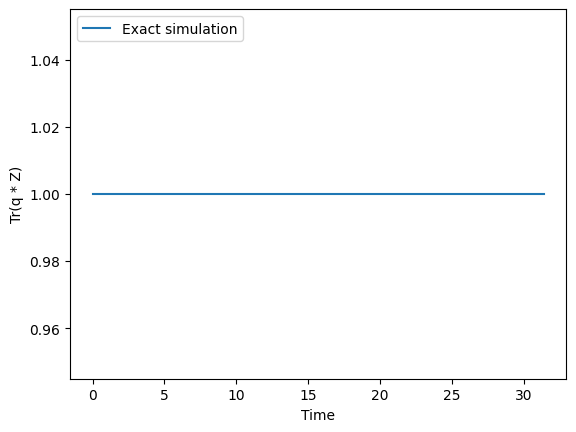

In [12]:
import matplotlib.pyplot as plt

rho = rho_0
exact_trace_sigmaZ_rho = []
for t in time_vec:
    sum = 0
    for j in np.arange(1, J + 1, 1):
        # Simple part
        sum = sum + V_period(j, t) @ rho @ V_period(j, t).conj().trans()
        # Anti-commuting part
        sum = sum - 0.5 * (
            V_period(j, t).conj().trans() @ V_period(j, t) @ rho
            + rho @ V_period(j, t).conj().trans() @ V_period(j, t)
        )
    delta_rho = -1j * (H_period(t) @ rho - rho @ H_period(t)) + sum
    rho = rho + dt * delta_rho
    exact_trace_sigmaZ_rho.append((rho @ rho_0).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * Z)")
plt.plot(time_vec, exact_trace_sigmaZ_rho, label="Exact simulation")
plt.legend(loc="upper left")

### First order approximation

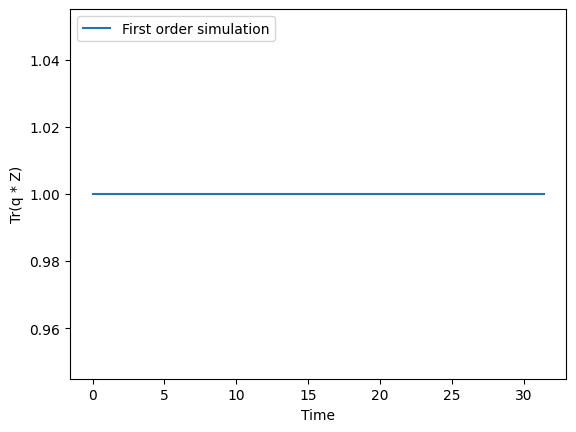

In [64]:
import math

import matplotlib.pyplot as plt
import numpy as np

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, ket_0)

rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = rho_0
first_order_trace_sigmaZ_rho = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(tensor(rho_ancilla, rho))
    # First element of taylor approximation, I
    taylor_aprox = Qobj(
        qeye(np.power(2, total_system_size)),
        dims=[[ancilla_dim, system_size_dim], [ancilla_dim, system_size_dim]],
    )
    # Custom size Taylor approximation
    for i in np.arange(1, taylor_aprox_order, 1):
        tmp = H_tilde_first_order(t)
        for _ in np.arange(1, i, 1):
            tmp = tmp @ H_tilde_first_order(t)
        taylor_aprox = taylor_aprox + np.power(-1j * dt, i) / math.factorial(i) * tmp

    left_tmp = taylor_aprox
    rigth_tmp = taylor_aprox.conj().trans()
    evolved_system = left_tmp @ system @ rigth_tmp
    rho = evolved_system.ptrace(1)
    first_order_trace_sigmaZ_rho.append((rho @ rho_0).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * Z)")
plt.plot(time_vec, first_order_trace_sigmaZ_rho, label="First order simulation")
plt.legend(loc="upper left")

### Second order approximation

In [65]:
import math

import numpy as np

# Second order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, ket_0)

rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = rho_0
second_order_trace_sigmaZ_rho = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(tensor(rho_ancilla, rho))
    # First element of taylor approximation, I
    taylor_aprox = Qobj(
        qeye(np.power(2, total_system_size)),
        dims=[[ancilla_dim, system_size_dim], [ancilla_dim, system_size_dim]],
    )
    # Custom size Taylor approximation
    for i in np.arange(1, taylor_aprox_order, 1):
        tmp = H_tilde_second_order(t)
        for _ in np.arange(1, i, 1):
            tmp = tmp @ H_tilde_second_order(t)
        taylor_aprox = taylor_aprox + np.power(-1j * dt, i) / math.factorial(i) * tmp

    left_tmp = taylor_aprox
    rigth_tmp = taylor_aprox.conj().trans()
    evolved_system = left_tmp @ system @ rigth_tmp
    rho = evolved_system.ptrace(1)
    second_order_trace_sigmaZ_rho.append((rho @ Z).tr())
    
plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * Z)")
plt.plot(time_vec, second_order_trace_sigmaZ_rho, label="Second order simulation")
plt.legend(loc="upper left")

NameError: name 'second_order_trace_sigmaZ_rho' is not defined

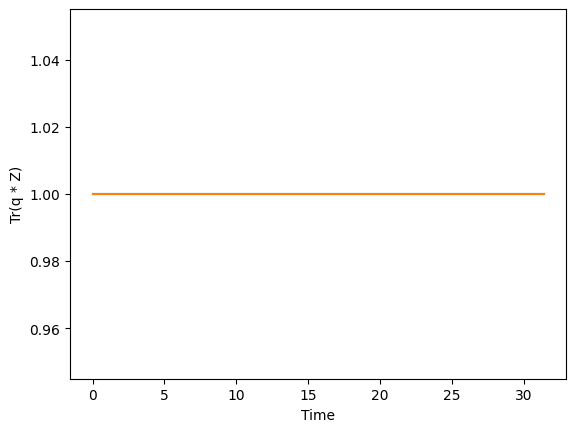

In [66]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * Z)")
plt.plot(time_vec, exact_trace_sigmaZ_rho, label="Exact simulation")
plt.plot(time_vec, first_order_trace_sigmaZ_rho, label="First order approximation")
plt.plot(time_vec, second_order_trace_sigmaZ_rho, label="Second order approximation")
plt.legend(loc="upper left")